# Supernova Classification with Machine Learning
## Dr. Michelle Lochner
*ESAC Data Analysis and Statistics Workshop 2017*

This tutorial aims to give an introduction to the principles of basic machine learning, using an example problem of supernova classification. 

This is based on: <br>
["Photometric Supernova Classification With Machine Learning"](https://arxiv.org/abs/1603.00882), Lochner et al. (2016)  <br>

And [this](https://github.com/MichelleLochner/ml-tutorial) even simpler tutorial.

*Further reading (see notes for more detailed references)*
- [sncosmo](https://sncosmo.readthedocs.io)
- [scikit-learn](http://scikit-learn.org/)
- The supernova classification [challenge](https://arxiv.org/abs/1001.5210) and [results](https://arxiv.org/abs/1008.1024)
- [SALT2 template fitting](https://arxiv.org/abs/astro-ph/0701828)

## Background

Supernova classification is a hot topic in astronomy at the moment. It's well known that there are several types of supernovae and to a cosmologist, only one of them is really useful: a Ia. Astrophysicists studying supernovae also need to know if they're dealing with a core collapse or Ia supernova. The problem is, traditionally the only way to truly accurately type a supernova is with a spectrum. In current and future surveys such as DES and LSST, there will be simply too many supernovae detected to follow them up spectroscopically. If we want to make use of this large dataset of photometric supernovae, we need a way to automatically classify them based on photometry alone (that is the light curve of the supernova in several different colour filters).

Since we will generally have a small training set of supernovae that have been spectroscopically typed, this is a great problem for supervised machine learning.

In this tutorial, you will go through the same procedure as you would for any supervised machine learning problem. You will first extract meaningful, scientifically driven features from raw data. You will decide how to split your data into training, validation and test sets. And finally, you will choose a machine learning algorithm to classify the supernovae and evaluate the results. 

**Data**<br>
The data we will use is the same as in Lochner et al. (2016), a subset of simulations from the Photometric Supernova Classification Challenge (SPCC, Kessler et al. 2010). The data consists of light curves (brightness as a function of time) in four different filter bands, with metadata including the type and the redshift. I have provided a subset of the data in an astropy table format.

**Features**<br>
The features we will use will be from a SALT-II model fit (Guy et al. 2007), which is an empirically determined model (based on spectral time series data) with 5 parameters:<br>
z - supernova redshift<br>
t0 - time of peak flux<br>
x0 - related to amplitude of the supernova<br>
x1 - related to the stretch of the supernova<br>
c - related to the colour of the supernova<br>

The package `sncosmo` can be used to fit these features to each light curve in the dataset. We expect it to fit well for Ia's and not so well for non-Ia's. 

**Classification**<br>
We'll use `sklearn` for classification. It will be up to you to apply the concepts covered in the lecture, including training/test splits, cross-validation, algorithm choice and measuring performance. 

In [1]:
from __future__ import division, print_function

import time
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt

import sncosmo
from astropy.table import Table

# Used to normalise features
from sklearn.preprocessing import StandardScaler 
# Used for hyperparameter optimisation and to avoid overfitting
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Some example algorithms you can try using (sklearn has many more)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
%matplotlib inline

# Section 1: Setup

### How to read in a supernova light curve as an astropy table

Unzip the data (if not already unzipped)

In [2]:
data_root = os.path.join('data','')

if not os.path.exists(data_root):
    subprocess.call(['unzip', 'data.zip'])

I've saved the supernova light curves in a format that `sncosmo` can read: an astropy table. The cell below reads in a single object's data and displays the table. 

The columns are: <br>
`mjd`: Time in days since the first observation of the supernova <br>
`filter`: Which filter band the observation is in (i.e. which colour)<br>
`flux`: The flux (brightness) in that band<br>
`flux_error`: Uncertainty on the flux due to instrumental noise<br>
`zp`: Zero point (The magnitude the flux is calibrated to)<br>
`zpsys`: The system used to calibrate the flux

Here's what a light curve looks like in astropy table format:

In [3]:
ls

README.md                     neural_net2.jpeg*
convnet.jpeg*                 neural_net2a.jpeg*
data/                         plots/
data.zip                      pre_workshop_questions.pdf
deep_learning_example.ipynb*  salt2_features.txt
environment.yml               sdss_galaxies_tutorial.ipynb
labels.txt                    spectra.npy
machine_learning_notes.pdf    supernova_tutorial.ipynb
metadata.npy


In [4]:
lc_file = os.path.join(data_root, '34.dat')
lc = Table.read(lc_file, format='ascii')


In [29]:
a=np.genfromtxt('salt2_features.txt', names=True, dtype=None)

In [47]:
a['z'][860:]
np.argmin(a['z'])

213

# Section 2: Feature extraction

In [5]:
def fit_supernova(lc):
    """
    Small function to fit a light curve with the SALT2 model, using sncosmo and iminuit.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    z, t0, x0, x1, c
        Best-fitting parameters of the model
    """
    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)

    return res[0].parameters

In [6]:
mjds= np.linspace(-30,100,30)

def measure_GPdiscretetrend(lc):
    """
    Small function to fit a light curve with GP and extract per filter per day features.
    
    Parameters
    -----------
    lc : astropy.table.Table
        Light curve (in the format sncosmo expects)
    
    Returns
    ----------
    
    """
    
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
    
    mjdsT= np.atleast_2d(mjds).T
    #X,y in all four filters
    filt_desg= lc['filter']=='desg'
    mjd_g= np.atleast_2d(lc['mjd'][filt_desg].data).T
    flux_g=lc['flux'][filt_desg].data 
    err_flux_g=lc['flux_error'][filt_desg].data

    filt_desr= lc['filter']=='desr'
    mjd_r= np.atleast_2d(lc['mjd'][filt_desr].data).T
    flux_r=lc['flux'][filt_desr].data
    err_flux_r=lc['flux_error'][filt_desr].data

    filt_desi= lc['filter']=='desi'
    mjd_i= np.atleast_2d(lc['mjd'][filt_desi].data).T
    flux_i=lc['flux'][filt_desi].data
    err_flux_i=lc['flux_error'][filt_desi].data

    filt_desz= lc['filter']=='desz'
    mjd_z= np.atleast_2d(lc['mjd'][filt_desz].data).T
    flux_z=lc['flux'][filt_desz].data
    err_flux_z=lc['flux_error'][filt_desz].data

    bnds = {'z':(0.01, 1.5), 't0':(-100,100),'x0':(-1e-3, 1e-3), 'x1':(-3, 3), 'c':(-0.5, 0.5)}
    mod = sncosmo.Model('salt2-extended')
    res = sncosmo.fit_lc(lc, mod, vparam_names=mod.param_names, bounds=bnds, minsnr=0)
    to= res[0].parameters[1]

    if (np.min(mjd_g-to)>-10.)|(np.max(mjd_g-to)<40.)|(np.max(flux_r)<20.):
        return 0.
    else:
        peak_mjd_g = mjd_g-to

        kernel = C(1.0, (0.01, 100)) * RBF(35, (20, 150))
        n_opt=20
        gp_g = GaussianProcessRegressor(kernel=kernel, alpha=(err_flux_g / flux_g) ** 2, n_restarts_optimizer=n_opt)
        gp_r = GaussianProcessRegressor(kernel=kernel, alpha=(err_flux_r / flux_r) ** 2, n_restarts_optimizer=n_opt)
        gp_i = GaussianProcessRegressor(kernel=kernel, alpha=(err_flux_i / flux_i) ** 2, n_restarts_optimizer=n_opt)
        gp_z = GaussianProcessRegressor(kernel=kernel, alpha=(err_flux_z / flux_z) ** 2, n_restarts_optimizer=n_opt)

        gp_g.fit(mjd_g-to, flux_g)
        flux_g_pred, err_flux_g_pred = gp_g.predict(mjdsT, return_std=True)
        gp_r.fit(mjd_r-to, flux_r)
        flux_r_pred, err_flux_r_pred = gp_r.predict(mjdsT, return_std=True)
        gp_i.fit(mjd_i-to, flux_i)
        flux_i_pred, err_flux_i_pred = gp_i.predict(mjdsT, return_std=True)
        gp_z.fit(mjd_z-to, flux_z)
        flux_z_pred, err_flux_z_pred = gp_z.predict(mjdsT, return_std=True)
        
        dict_results={
            'gband_obs':[mjd_g-to, flux_g, err_flux_g],
            'gband_fit':[mjds, flux_g_pred, err_flux_g_pred],
            'rband_obs':[mjd_r-to, flux_r, err_flux_r],
            'rband_fit':[mjds, flux_r_pred, err_flux_r_pred],
            'iband_obs':[mjd_i-to, flux_i, err_flux_i],
            'iband_fit':[mjds, flux_i_pred, err_flux_i_pred],
            'zband_obs':[mjd_z-to, flux_z, err_flux_z],
            'zband_fit':[mjds, flux_z_pred, err_flux_z_pred],
        }
        
        return dict_results

In [7]:

for i in range(2000):
    lcnumb='%i' % (i)
    lc_file = os.path.join(data_root, '%s.dat'%lcnumb)
    lc = Table.read(lc_file, format='ascii')
    R=measure_GPdiscretetrend(lc)
    if R==0.:
        continue
    else:
        plt.plot(mjds, R['gband_fit'][1], color='g', label='desg')
        plt.fill_between(mjds, R['gband_fit'][1]-R['gband_fit'][2], R['gband_fit'][1]+R['gband_fit'][2]\
                         , color='g', alpha=0.3)
        plt.errorbar(R['gband_obs'][0], R['gband_obs'][1], yerr= R['gband_obs'][2], marker='o',\
                    mfc='g', mec='g', ecolor='g', linestyle='None')

        plt.plot(mjds, R['rband_fit'][1], color='r', label='desr')
        plt.fill_between(mjds, R['rband_fit'][1]-R['rband_fit'][2], R['rband_fit'][1]+R['rband_fit'][2]\
                         , color='r', alpha=0.3)
        plt.errorbar(R['rband_obs'][0], R['rband_obs'][1], yerr= R['rband_obs'][2], marker='o',\
                    mfc='r', mec='r', ecolor='r', linestyle='None')
        
        plt.plot(mjds, R['iband_fit'][1], color='k',label='desi')
        plt.fill_between(mjds, R['iband_fit'][1]-R['iband_fit'][2], R['iband_fit'][1]+R['iband_fit'][2]\
                         , color='k', alpha=0.3)
        plt.errorbar(R['iband_obs'][0], R['iband_obs'][1], yerr= R['iband_obs'][2], marker='o',\
                    mfc='k', mec='k', ecolor='k', linestyle='None')
        plt.xlabel('days')
        plt.ylim(-50,)
        plt.legend()
        plt.grid()
        plt.title('SN lightcurve %s'%lcnumb)
        print ('Saving lc%s.png'%lcnumb)
        fig.savefig('./plots/lc%s.png'%lcnumb)
        plt.close(fig)


Saving lc0.png
Saving lc4.png
Saving lc5.png
Saving lc6.png
Saving lc11.png
Saving lc15.png
Saving lc18.png
Saving lc21.png


/Users/mariavincenzi/anaconda2_7/lib/python2.7/site-packages/sncosmo/fitting.py:539: RuntimeWarning: Exception Occured 
fcn is called with following arguments:
     z = +0.693027
    t0 = +57.914143
    x0 = +0.000005
    x1 = -2.077238
     c = -0.070584

  d, l = m.migrad(ncall=maxcall)


KeyboardInterrupt: 

In [11]:
mjds_selected=mjds[4:18]
df_labels=['M_%.3f'%mjd for mjd in mjds_selected]+['filter','lc']
df = pd.DataFrame(columns=df_labels)

row_count=0
for i in range(2000):
    lcnumb='%i' % (i)
    lc_file = os.path.join(data_root, '%s.dat'%lcnumb)
    lc = Table.read(lc_file, format='ascii')
    R=measure_GPdiscretetrend(lc)
    if R==0.:
        continue
    else:
        print ('Analizing %s.dat'%lcnumb)
        df.loc[row_count] = list(R['gband_fit'][1][4:18])+['desg', lcnumb]
        df.loc[row_count+1] = list(R['rband_fit'][1][4:18])+['desr', lcnumb]
        df.loc[row_count+2] = list(R['iband_fit'][1][4:18])+['desi', lcnumb]
        df.loc[row_count+3] = list(R['zband_fit'][1][4:18])+['desz', lcnumb]
        row_count += 4

Analizing 0.dat
Analizing 4.dat
Analizing 5.dat
Analizing 6.dat
Analizing 11.dat
Analizing 15.dat
Analizing 18.dat
Analizing 21.dat
Analizing 23.dat
Analizing 25.dat
Analizing 31.dat
Analizing 34.dat
Analizing 38.dat
Analizing 40.dat
Analizing 41.dat
Analizing 44.dat
Analizing 48.dat
Analizing 51.dat
Analizing 52.dat
Analizing 53.dat
Analizing 63.dat
Analizing 66.dat
Analizing 70.dat
Analizing 72.dat
Analizing 76.dat
Analizing 82.dat
Analizing 86.dat
Analizing 88.dat
Analizing 91.dat
Analizing 93.dat
Analizing 96.dat
Analizing 103.dat
Analizing 105.dat
Analizing 106.dat
Analizing 114.dat
Analizing 115.dat
Analizing 116.dat
Analizing 119.dat
Analizing 121.dat
Analizing 129.dat
Analizing 130.dat
Analizing 131.dat
Analizing 133.dat
Analizing 134.dat
Analizing 136.dat
Analizing 146.dat
Analizing 148.dat
Analizing 149.dat
Analizing 154.dat
Analizing 157.dat
Analizing 159.dat
Analizing 162.dat
Analizing 164.dat
Analizing 167.dat
Analizing 168.dat
Analizing 170.dat
Analizing 171.dat
Analizing

Analizing 1399.dat
Analizing 1400.dat
Analizing 1402.dat
Analizing 1403.dat
Analizing 1408.dat
Analizing 1411.dat
Analizing 1415.dat
Analizing 1416.dat
Analizing 1420.dat
Analizing 1425.dat
Analizing 1433.dat
Analizing 1436.dat
Analizing 1437.dat
Analizing 1445.dat
Analizing 1449.dat
Analizing 1451.dat
Analizing 1452.dat
Analizing 1456.dat
Analizing 1458.dat
Analizing 1461.dat
Analizing 1462.dat
Analizing 1463.dat
Analizing 1465.dat
Analizing 1466.dat
Analizing 1467.dat
Analizing 1472.dat
Analizing 1474.dat
Analizing 1475.dat
Analizing 1477.dat
Analizing 1479.dat
Analizing 1482.dat
Analizing 1485.dat
Analizing 1486.dat
Analizing 1487.dat
Analizing 1489.dat
Analizing 1490.dat
Analizing 1494.dat
Analizing 1496.dat
Analizing 1500.dat
Analizing 1501.dat
Analizing 1502.dat
Analizing 1503.dat
Analizing 1508.dat
Analizing 1509.dat
Analizing 1511.dat
Analizing 1513.dat
Analizing 1516.dat
Analizing 1517.dat
Analizing 1519.dat
Analizing 1520.dat
Analizing 1521.dat
Analizing 1525.dat
Analizing 15

In [23]:
df.first

<bound method DataFrame.first of       M_-12.069   M_-7.586   M_-3.103    M_1.379    M_5.862   M_10.345  \
0     22.494645  27.706813  25.082012  16.012106   4.951192  -3.149101   
1     30.578289  30.855734  29.263722  26.467754  23.217643  20.064195   
2     17.483092  18.937600  18.545418  17.546422  17.055973  17.507219   
3     19.966991  23.028088  25.141016  26.105492  25.811458  24.496769   
4     84.235330  84.461305  73.694842  59.614987  48.345665  41.847610   
5     65.379885  68.854784  58.169745  44.823148  37.976953  39.469046   
6     67.350518  76.741380  77.024916  73.592037  70.208680  67.961156   
7     48.156634  52.160349  53.976320  54.502309  53.963585  52.782101   
8      9.534918  10.028694   8.765567   6.400666   4.177496   3.206978   
9     33.286352  47.716721  54.276789  51.867269  43.039471  32.146680   
10    33.821742  48.989378  58.889922  61.544434  57.400284  48.657065   
11    34.074264  47.234974  54.598757  55.217911  50.166842  42.116259   
12   

(0, 200)

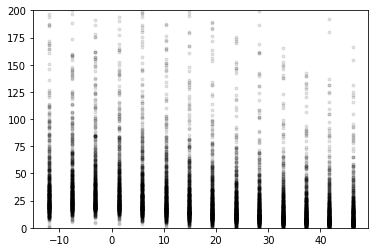

In [28]:
#plt.hist(df.query('filter=="desr"')['M_1.379'].values, bins=np.linspace(0,200,100))

for m in mjds_selected:
    plt.plot(m*np.ones(len(df.query('filter=="desr"')['M_%.3f'%m].values)),\
        df.query('filter=="desr"')['M_%.3f'%m].values, '.k', alpha=0.1)


In [40]:
np.argmax(df.query('filter=="desr"')['M_%.3f'%m].values)

df.query('filter=="desr"')[280:]

,M_-12.069,M_-7.586,M_-3.103,M_1.379,M_5.862,M_10.345,M_14.828,M_19.310,M_23.793,M_28.276,M_32.759,M_37.241,M_41.724,M_46.207,filter,lc
1121,29.749186,31.953299,30.764605,27.793655,24.368371,21.138579,18.187313,15.384514,12.684684,10.224071,8.248447,6.981215,6.519608,6.790292,desr,836
1125,18.868086,28.981471,33.512070,33.172158,29.485519,24.117776,18.392777,13.130856,8.743631,5.416626,3.235561,2.207388,2.213611,2.968351,desr,842
1129,20.120867,19.841739,19.010092,17.986952,16.867531,15.637756,14.387101,13.381199,12.919188,13.084249,13.597790,13.923419,13.580844,12.464311,desr,845
1133,28.881061,39.280112,44.371989,43.382266,37.138664,27.735965,17.793329,9.608631,4.519713,2.666018,3.178181,4.677020,5.875161,6.057159,desr,850
1137,34.083842,38.660036,38.247412,35.056063,31.320134,28.179227,25.582479,23.021185,20.343605,17.992983,16.589384,16.330220,16.773944,17.180364,desr,853
1141,32.240820,29.884710,31.179268,32.425076,31.813696,29.871458,28.238934,27.924400,28.483753,28.705056,28.029265,27.266374,27.767474,29.599688,desr,854
1145,54.783299,52.579658,48.158474,43.949310,41.282867,40.296712,40.304965,40.240731,39.045103,36.077133,31.507869,26.421358,22.360148,20.441832,desr,855
1149,35.155909,42.402979,44.857955,43.222752,38.842570,32.825809,25.785058,18.184031,10.789296,4.718168,0.990144,-0.061767,0.952786,2.763833,desr,857
1153,41.709508,44.627852,46.597199,47.639086,47.628277,46.651274,45.112186,43.498979,42.108375,41.035198,40.366365,40.208975,40.311461,39.522727,desr,858
1157,1935.727539,3077.647995,3708.392952,3729.315197,3293.084283,2648.958019,2010.640909,1497.840489,1142.471890,922.883375,796.793488,722.634854,670.392480,624.721466,desr,860


Best fitting SALT2 parameters: [z, t0, x0, x1, c]:
[  8.57230383e-01  -3.78042102e+01   3.70568995e-06  -2.81316916e+00
   7.15027538e-02]


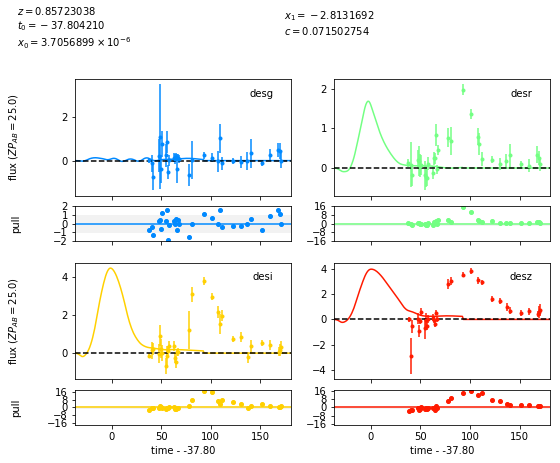

In [402]:
prms = fit_supernova(lc)
print('Best fitting SALT2 parameters: [z, t0, x0, x1, c]:')
print(prms)
mod = sncosmo.Model('salt2-extended')
mod.parameters = prms
sncosmo.plot_lc(lc, mod);


Let's fit one of these light curves:

sncosmo can make a nice plot to show if the fit works well

**I've already extracted features for you (because it takes a little while) in a file called "salt2_features.txt"**<br>
Load the features into a numpy array. There's another file called "labels.txt" which has the true label for each object (what we're trying to predict). The labels are:

1 - Ia<br>
2 - II<br>
3 - Ibc<br>

# Section 3: Classification

## 1. Split into training and test sets

What's a reasonable choice here for how much data should go into your test set? What are you going to do to ensure you don't overfit?

## 2. Scale the features
What algorithm are you planning on using? Does it require you scale the features in any way?

## 3. Choose a machine learning algorithm and train

## 4. Run your trained algorithm to predict the labels 

## 5. Compute the accuracy, precision and recall of your classified objects
Don't use sklearn's functions here, compute these yourself to see how it's done

## 6. A better metric - create a ROC curve for your classified supernovae, with Ia as the positive class
You'll need to go back and predict the probability for each object being a Ia. You can then use sklearn's `roc_curve` and `roc_auc_score` functions. Beware: these will expect a binary classification...

## 7. What's the best you can get?
I can get an AUC of around 0.93 for this dataset. Try to see if you can beat that! Try different algorithms and hyperparameters. Think about optimising the hyperparameters, what metric should you be optimising for? Just ensure you always keep aside a test set (and maybe try different test sets) to avoid overfitting.